In [2]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import numpy as np

In [3]:
def __mkdir(*args):
    path = os.path.join(*args)
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
    return path

In [4]:
# Set working directory as the current directory of the ipython notebook
working_dir = os.getcwd()
data_dir = __mkdir(working_dir, "data")

In [5]:
mm = pd.read_pickle(os.path.join(data_dir, 'mm.pckl')) 
mm.head(10)

,ngram,nct_id,criteria_id,ngram_index,score,term,cui,stype,cid
0,"((time, NN),)",NCT00001149,0,0,8.34,Time,C0040223,tmco,[G01.910]
1,"((uncontrolled, VBN), (seizure, NNS), (at, IN))",NCT00001149,0,8,16.21,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
2,"((of, IN), (seizure, NNS), (during, IN))",NCT00001149,0,10,16.21,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
3,"((seizure, NNS), (at, IN), (the, DT))",NCT00001149,0,11,16.21,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
4,"((pattern, NN), (of, IN), (seizure, NNS))",NCT00001149,0,12,16.07,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
5,"((seizure, NNS), (during, IN), (the, DT))",NCT00001149,0,13,16.21,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
6,"((seizure, NNS), (at, IN))",NCT00001149,0,17,16.26,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
7,"((the, DT), (present, NN), (time, NN))",NCT00001149,0,18,6.74,Time,C0040223,tmco,[G01.910]
8,"((seizure, NNS),)",NCT00001149,0,21,17.80,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."
9,"((uncontrolled, VBN), (seizure, NNS))",NCT00001149,0,22,16.26,Seizures,C0036572,sosy,"[C10.228.140.490.631, C10.597.742, C23.888.592..."


In [6]:
medex = pd.read_pickle(os.path.join(data_dir, 'medex.pckl')) 
medex.head(10)

,nct_id,criteria_id,drug_name,drug_form,strength,dose,route,frequency,duration,cui,generic_name,term
0,NCT00001205,8,corticosteroid,,,,,,,,corticosteroid,corticosteroid
1,NCT00001205,8,immunosuppressive,,,,,,,,immunosuppressive,immunosuppressive
2,NCT00001205,11,praziquantel,,,,,,,C0032911,praziquantel,praziquantel
3,NCT00001205,11,albendazole,,,,,,,C0001911,albendazole,albendazole
4,NCT00001205,11,methotrexate,,,,,,,C0025677,methotrexate,methotrexate
5,NCT00001205,11,corticosteroid,,,,,,,,corticosteroid,corticosteroid
6,NCT00001205,11,etanercept,,,,,,,C0717758,etanercept,etanercept
7,NCT00001205,14,anthelmintic,,,,,,,,anthelmintic,anthelmintic
8,NCT00001205,14,corticosteroid,,,,,,,,corticosteroid,corticosteroid
9,NCT00001205,14,immunosuppressive,,,,,,,,immunosuppressive,immunosuppressive


In [14]:
def get_terms_to_docs_medex(mm):
    data = []
#     index = []
    #for name, group in mm.groupby('cui'):
    for name, group in mm.groupby('term'):
        g = group.drop_duplicates(subset='nct_id')
        nctids = list(set(g.nct_id.values))
        term = g.term.values[0]
        cui = list(set(g.cui.values))
        #stype = g.stype.values[0]
        d = {'cui': cui, 'term': term, 'nct_ids': nctids, 'num_docs': len(nctids)}
        data.append(d)
#         index.append(name)
#     df = pd.DataFrame(data, index=index).sort_values(by='num_docs', ascending=False)
    df = pd.DataFrame(data).sort(['num_docs'], ascending=False)
    return df

def get_terms_to_docs_mm(mm):
    data = []
#     index = []
    for name, group in mm.groupby('cui'):
        g = group.drop_duplicates(subset='nct_id')
        nctids = g.nct_id.values
        term = g.term.values[0]
        stype = g.stype.values[0]
        d = {'cui': name, 'term': term, 'nct_ids': nctids, 'num_docs': len(nctids), 'stype': stype}
        data.append(d)
#         index.append(name)
#     df = pd.DataFrame(data, index=index).sort_values(by='num_docs', ascending=False)
    df = pd.DataFrame(data)
    return df

def get_docs_to_terms(mm, ctgov_data):
    data = []
#     index = []
    for name, group in mm.groupby('nct_id'):
        g = group.drop_duplicates(subset='cui')
        cuis = list(set(g.cui.values))
        terms = g.term.values
        title = ctgov_data[ctgov_data['id_info.nct_id'] == name].brief_title.values[0]
        url = 'https://clinicaltrials.gov/ct2/show/' + name
        d = {'cuis': cuis, 'terms': terms, 'nct_id': name, 'num_terms': len(cuis), 'title': title, 'url': url}
        data.append(d)
#         index.append(name)
#     df = pd.DataFrame(data, index=index).sort_values(by='num_docs', ascending=False)
    #df = pd.DataFrame(data).sort_values(by='num_terms', ascending=False)
    df = pd.DataFrame(data).sort(['num_terms'], ascending=False)
    return df

In [8]:
ctgov = pd.read_pickle(os.path.join(data_dir, 'ctgov.pckl'))
docs_to_terms_medex = get_docs_to_terms(medex, ctgov)
docs_to_terms_medex.to_pickle(os.path.join(data_dir, 'medex-trials.pckl'))
docs_to_terms_medex.head(100)

,cuis,nct_id,num_terms,terms,title,url
43,"[C0699931, , C0699606, C0085170, C0699601, C07...",NCT00057460,24,"[cimetidine (tagamet), cimetidine (tagamet), v...",Effect of Talampanel (an AMPA Receptor Blocker...,https://clinicaltrials.gov/ct2/show/NCT00057460
848,"[, C0002600, C0070166, C0530684, C0003299, C00...",NCT02535091,22,"[antiepileptic, phenobarbital (phenobarbitone)...",Safety and Pharmacokinetic Study of YKP3089 as...,https://clinicaltrials.gov/ct2/show/NCT02535091
225,"[, C0072980, C0025872, C0021747, C0008783, C00...",NCT00425113,19,"[isoniazid, rifampicin (rifampin), ofloxacin, ...",Metronidazole for Pulmonary Tuberculosis (Sout...,https://clinicaltrials.gov/ct2/show/NCT00425113
398,"[, C0006949, C2757014, C0048044, C0220839, C03...",NCT00931619,18,"[antiepileptic, sodium, zonisamide (zonegran),...",GABA/Glutamate Balance in Temporal Lobe Epilep...,https://clinicaltrials.gov/ct2/show/NCT00931619
214,"[C0006949, C0377265, C0080356, C0060926, C0068...",NCT00394927,14,"[topiramate (topamax), tiagabine, pregabalin (...",Adverse Event Scale in Patients With Epilepsy ...,https://clinicaltrials.gov/ct2/show/NCT00394927
231,"[C1701110, , C0024467, C1262867, C0001924, C08...",NCT00441142,14,"[gadolinium, vandetanib, zd6474, temozolomide,...",Zactima With Temodar During Radiation Treatmen...,https://clinicaltrials.gov/ct2/show/NCT00441142
748,"[, C0006949, C0042523, C0244656, C2936807, C02...",NCT02187809,13,"[clobazam, verapamil, stiripentol, felbamate (...",Safety and Tolerability of Clobazam as Adjunct...,https://clinicaltrials.gov/ct2/show/NCT02187809
832,"[, C0006949, C0060135, C0033148, C0003299, C00...",NCT02495844,13,"[antiepileptic, contraceptive, guaifenesin, pr...",A Study of UCB0942 in Adult Patients With High...,https://clinicaltrials.gov/ct2/show/NCT02495844
36,"[, C0072980, C0001924, C0987222, C0993472, C00...",NCT00050713,13,"[ace inhibitor, lisinopril, sirolimus (rapamyc...",Sirolimus Therapy for Idiopathic and Lupus Mem...,https://clinicaltrials.gov/ct2/show/NCT00050713
746,"[, C0006949, C0042523, C0244656, C2936807, C02...",NCT02174094,13,"[antiepileptic, verapamil, stiripentol, felbam...",Clobazam as Adjunctive Therapy in Paediatric P...,https://clinicaltrials.gov/ct2/show/NCT02174094


In [10]:
docs_to_terms_mm = get_docs_to_terms(mm, ctgov)
docs_to_terms_mm.to_pickle(os.path.join(data_dir, 'mm-trials.pckl'))
docs_to_terms_mm.head(100)

,cuis,nct_id,num_terms,terms,title,url
1126,"[C0023216, C0037638, C0684240, C0039082, C0007...",NCT02220972,183,"[Generalization (Psychology), Electroencephalo...",To Evaluate the Effect of Perampanel on Object...,https://clinicaltrials.gov/ct2/show/NCT02220972
310,"[C0033095, C0039082, C0546866, C0151636, C0024...",NCT00441142,181,"[Patients, Iodides, gliosarcoma, Volition, Gli...",Zactima With Temodar During Radiation Treatmen...,https://clinicaltrials.gov/ct2/show/NCT00441142
888,"[C0039082, C0013217, C0086582, C0032961, C0017...",NCT01713946,167,"[Male gender, Males, Europe, Volition, Female,...",A Placebo-controlled Study of Efficacy & Safet...,https://clinicaltrials.gov/ct2/show/NCT01713946
598,"[C0024523, C0039082, C0037981, C0017710, C0013...",NCT01070316,164,"[Female, Females, Woman, Male gender, Males, E...",Everolimus (RAD001) Therapy for Epilepsy in Pa...,https://clinicaltrials.gov/ct2/show/NCT01070316
446,"[C0004745, C0022067, C0024488, C0023901, C0039...",NCT00699972,159,"[Belarus, Legal Guardians, Writing (occupation...",Evaluating the Efficacy and Safety of E2007 (P...,https://clinicaltrials.gov/ct2/show/NCT00699972
447,"[C0004745, C0022067, C0024488, C0023901, C0039...",NCT00700310,158,"[Belarus, Legal Guardians, Writing (occupation...",Evaluating Efficacy and Safety of E2007 (Peram...,https://clinicaltrials.gov/ct2/show/NCT00700310
445,"[C0004745, C0022067, C0024488, C0023901, C0039...",NCT00699582,157,"[Belarus, Legal Guardians, Writing (occupation...",To Evaluate The Efficacy and Safety of E2007 (...,https://clinicaltrials.gov/ct2/show/NCT00699582
1019,"[C0018880, C0039082, C0024483, C0311335, C1720...",NCT01969851,151,"[Oprelvekin, Seizures, Diaries, Maintenance, C...",A Study to Investigate the Safety and Efficacy...,https://clinicaltrials.gov/ct2/show/NCT01969851
1022,"[C0033095, C0027853, C0027855, C0016663, C0039...",NCT01977651,149,"[Adenocarcinoma, Prostate, Male Castration, Ho...",A Study to Evaluate the Potential Increased Ri...,https://clinicaltrials.gov/ct2/show/NCT01977651
121,"[C0004745, C0024488, C0684240, C0024483, C1113...",NCT00144690,149,"[Patients, Writing (occupation or discipline),...",E2007 Given as Adjunctive Therapy in Patients ...,https://clinicaltrials.gov/ct2/show/NCT00144690


In [15]:
terms_to_docs_medex = get_terms_to_docs_medex(medex)
terms_to_docs_medex.to_pickle(os.path.join(data_dir, 'medex-terms.pckl'))
terms_to_docs_medex.head(100)

,cui,nct_ids,num_docs,term
49,[C0003299],"[NCT00597285, NCT00152373, NCT00698581, NCT026...",194,antiepileptic
83,[],"[NCT00866775, NCT00152373, NCT00849212, NCT020...",120,benzodiazepine
257,"[C0060135, C0728742]","[NCT00866775, NCT02607904, NCT01338805, NCT011...",88,felbamate (felbatol)
372,"[, C0376261]","[NCT00416195, NCT00979004, NCT00956696, NCT001...",85,lactate
162,[],"[NCT00167245, NCT01335867, NCT00152503, NCT021...",75,contraceptive
357,[C1875327],"[NCT00790400, NCT00441896, NCT01648101, NCT021...",74,investigational drug
705,"[, C0048044]","[NCT01073579, NCT00441896, NCT00866775, NCT013...",73,vigabatrin (sabril)
114,"[, C0006949, C0719149]","[NCT00542802, NCT00616759, NCT00021866, NCT022...",66,"carbamazepine (tegretol, carbatrol)"
378,"[C1827202, C0377265, null, C0876060]","[NCT02098941, NCT01801072, NCT00855738, NCT020...",64,levetiracetam (keppra)
516,"[, C1123532, C0031507]","[NCT00167245, NCT00021866, NCT00869622, NCT012...",60,phenytoin (dilantin)


In [16]:
terms_to_docs_mm = get_terms_to_docs_mm(mm)
terms_to_docs_mm.to_pickle(os.path.join(data_dir, 'mm-terms.pckl'))
terms_to_docs_mm.head(100)

,cui,nct_ids,num_docs,stype,term
0,C0000702,[NCT01532791],1,"bacs,nnon","DNA, A-Form"
1,C0000726,"[NCT00059137, NCT00254722, NCT00591487, NCT006...",19,blor,Abdomen
2,C0000727,[NCT01911702],1,sosy,"Abdomen, Acute"
3,C0000737,"[NCT00688662, NCT02428595]",2,sosy,Abdominal Pain
4,C0000768,"[NCT00001404, NCT00004399, NCT00004403, NCT000...",92,cgab,Congenital Abnormality
5,C0000772,"[NCT00873847, NCT01426542]",2,cgab,Multiple congenital anomalies
6,C0000786,"[NCT00513240, NCT01730170]",2,patf,Spontaneous abortion
7,C0000832,"[NCT00614744, NCT01222247]",2,patf,Abruptio Placentae
8,C0000833,"[NCT01380028, NCT01436695, NCT01977651, NCT022...",4,dsyn,Abscess
9,C0000854,"[NCT00056576, NCT00104416, NCT00144872, NCT001...",44,npop,Process of absorption


In [17]:
trials_medex = pd.read_pickle(os.path.join(data_dir, 'medex-trials.pckl'))
trials_mm = pd.read_pickle(os.path.join(data_dir, 'mm-trials.pckl'))
trials_mm.head()

,cuis,nct_id,num_terms,terms,title,url
1126,"[C0023216, C0037638, C0684240, C0039082, C0007...",NCT02220972,183,"[Generalization (Psychology), Electroencephalo...",To Evaluate the Effect of Perampanel on Object...,https://clinicaltrials.gov/ct2/show/NCT02220972
310,"[C0033095, C0039082, C0546866, C0151636, C0024...",NCT00441142,181,"[Patients, Iodides, gliosarcoma, Volition, Gli...",Zactima With Temodar During Radiation Treatmen...,https://clinicaltrials.gov/ct2/show/NCT00441142
888,"[C0039082, C0013217, C0086582, C0032961, C0017...",NCT01713946,167,"[Male gender, Males, Europe, Volition, Female,...",A Placebo-controlled Study of Efficacy & Safet...,https://clinicaltrials.gov/ct2/show/NCT01713946
598,"[C0024523, C0039082, C0037981, C0017710, C0013...",NCT01070316,164,"[Female, Females, Woman, Male gender, Males, E...",Everolimus (RAD001) Therapy for Epilepsy in Pa...,https://clinicaltrials.gov/ct2/show/NCT01070316
446,"[C0004745, C0022067, C0024488, C0023901, C0039...",NCT00699972,159,"[Belarus, Legal Guardians, Writing (occupation...",Evaluating the Efficacy and Safety of E2007 (P...,https://clinicaltrials.gov/ct2/show/NCT00699972


In [20]:
terms_medex = pd.read_pickle(os.path.join(data_dir, 'medex-terms.pckl'))
terms_mm = pd.read_pickle(os.path.join(data_dir, 'mm-terms.pckl'))

top_terms_medex = terms_medex.sort('num_docs', ascending=False).head(100)
top_terms_medex = top_terms_medex.set_index('term')
top_terms_mm = terms_mm.sort('num_docs', ascending=False).head(100)
top_terms_mm = top_terms_mm.set_index('term')
top_terms_mm

,cui,nct_ids,num_docs,stype
term,,,,
Disease,C0012634,"[NCT00001205, NCT00001262, NCT00001289, NCT000...",818,dsyn
Seizures,C0036572,"[NCT00001149, NCT00001325, NCT00001489, NCT000...",719,sosy
History,C0019664,"[NCT00001149, NCT00001192, NCT00001666, NCT000...",651,ocdi
Historical aspects qualifier,C0019665,"[NCT00001149, NCT00001192, NCT00001666, NCT000...",651,inpr
Patients,C0030705,"[NCT00001149, NCT00001192, NCT00001205, NCT000...",618,podg
therapeutic aspects,C0039798,"[NCT00001205, NCT00001489, NCT00001666, NCT000...",607,ftcn
Epilepsy,C0014544,"[NCT00001325, NCT00001366, NCT00001489, NCT000...",584,dsyn
Belarus,C0006539,"[NCT00001149, NCT00001205, NCT00001289, NCT000...",489,geoa
Woman,C0043210,"[NCT00001666, NCT00001725, NCT00001932, NCT000...",446,popg


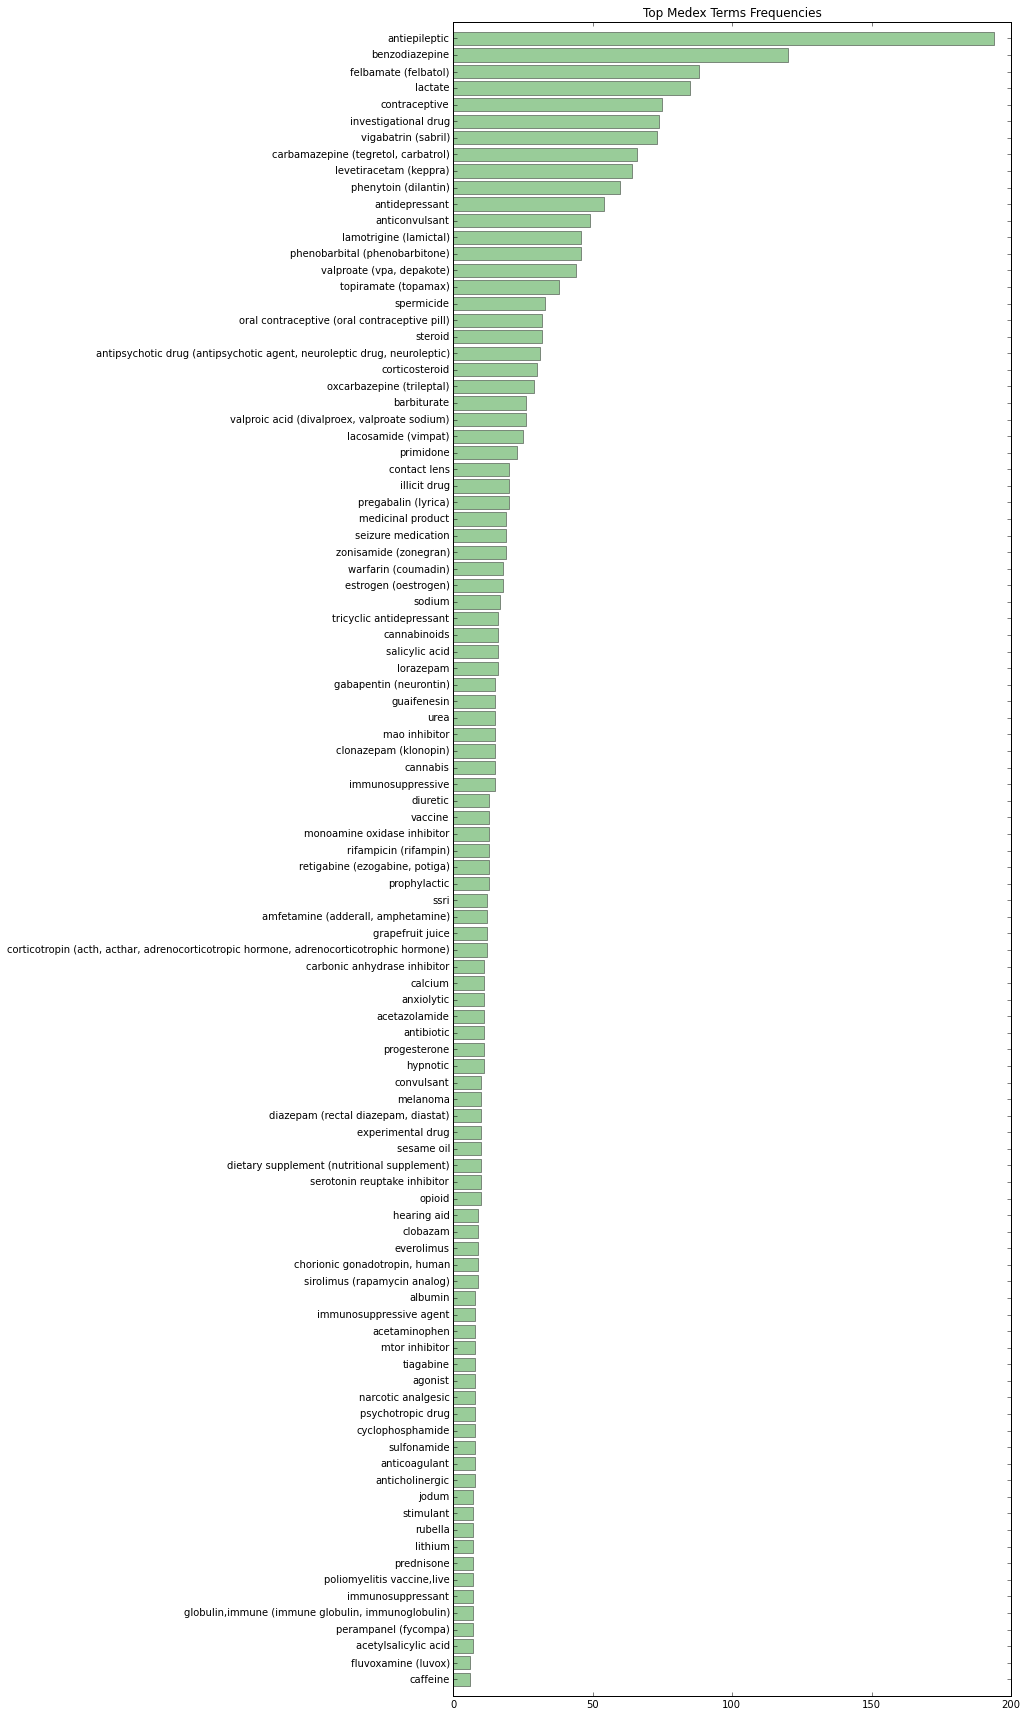

In [26]:
rcParams['figure.figsize'] = 10, 30 # control plot size
#top_terms_medex = terms_medex.sort('num_docs', ascending=False).head(100)
#print type(top_terms_medex.num_docs)
y_pos = np.arange(100)[::-1]
plt.barh(y_pos, list(top_terms_medex.num_docs), align='center', alpha=0.4, color="g")
plt.yticks(y_pos, list(top_terms_medex.term))
plt.ylim(-1, 100)
plt.title('Top Medex Terms Frequencies')

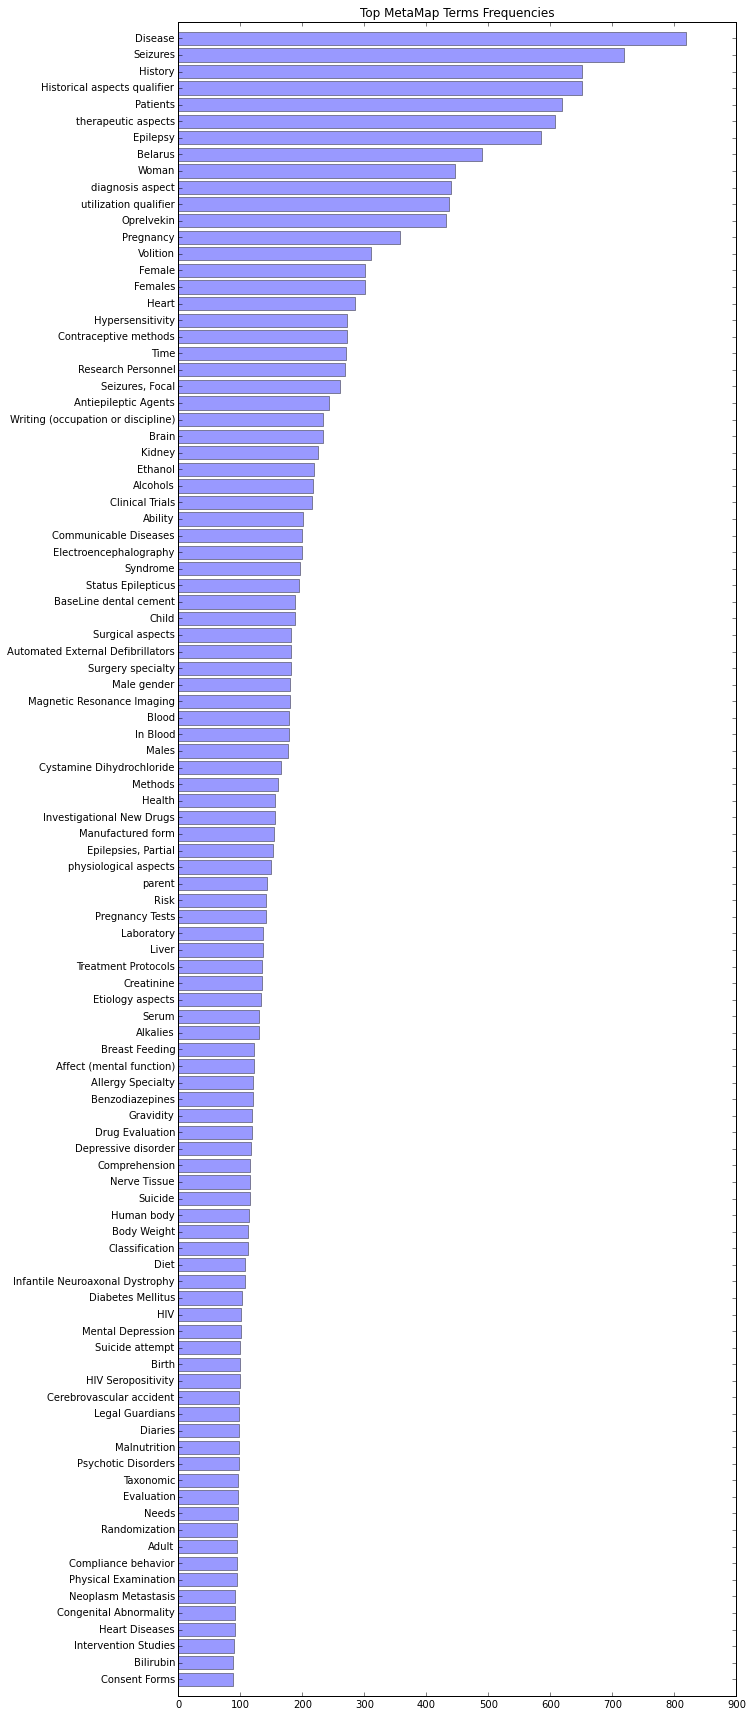

In [29]:
top_terms_mm = terms_mm.sort('num_docs', ascending=False).head(100)
plt.barh(y_pos, list(top_terms_mm.num_docs), align='center', alpha=0.4, color="b")
plt.yticks(y_pos, list(top_terms_mm.term))
plt.ylim(-1, 100)
plt.title('Top MetaMap Terms Frequencies')

# get_terms(N, k,m) and get_freqs realization

In [11]:
from operator import itemgetter

def get_freqs(terms, docs, perc=False):
    _docs = ('|'.join(doc) for doc in docs)
    cv = CountVectorizer(vocabulary=terms, analyzer=lambda doc: doc.split('|'))
    m = vect.transform(_docs)
    terms_freq = sorted([(term, round(float(freq)/len(docs), 2) if perc else freq) for term, freq in zip(terms, m.getnnz(0))], key=itemgetter(1), reverse=True)
    return terms_freq

def filter_terms(terms, curr_terms):
    _terms = list(set(terms) - set(curr_terms))
    return _terms

def filter_docs(docs, curr_terms, m):
    _docs = [doc for doc in docs if len(set(doc).intersection(set(curr_terms))) < m]
    return _docs

def get_terms(terms, docs, n=40, k=10, m=5):
    """
        (n, k, m) realization, which takes terms and docs and returns n terms with freqs
    """
    curr_terms_freq = []
    print len(docs), len(terms)
    while len(curr_terms_freq) < n:
        terms_freq = get_freqs(terms, docs, perc=False)
        curr_terms_freq += terms_freq[:k]
        curr_terms = [t[0] for t in curr_terms_freq]
        terms = filter_terms(terms, curr_terms)
        docs = filter_docs(docs, curr_terms, m)
        print len(docs), len(terms)
        print
    return curr_terms_freq[:n]
    

In [31]:
voc = terms_mm.term.values.tolist()
docs = [list(trial['terms']) for trial in trials_mm[['terms']].to_dict('records')]

In [13]:
trs = get_terms(voc, docs, n=40, k=5, m=2)
print trs

877 721


NameError: global name 'vect' is not defined